# H1 — Comparaison des 4 datasets : Activité broadband et puissance spectrale

## Objectif

Comparer l'activité LFP sur les 4 enregistrements (aversif-1, aversif-2, rewarded-1, rewarded-2)
après application d'un filtre notch à 50 Hz pour supprimer le bruit secteur.

## Plan
1. **Filtre notch 50 Hz** — suppression du bruit secteur (iirnotch, Q=30, zero-phase).
2. **Activité broadband (Welch 0.5–50 Hz)** — puissance totale par epoch, par région, par condition.
3. **Puissance relative par bande** — NREM I vs NREM II (aversif et rewarded).
4. **Puissance relative par bande** — REM I vs REM II (aversif et rewarded).
5. **Tests statistiques** — MWU bilatéral + test de permutation pondéré.
6. **Comparaison inter-fichiers** — av-1 vs av-2, rw-1 vs rw-2.
7. **Export Excel** — tableau récapitulatif.

## Méthode
- **Filtre** : Butterworth coupe-bande (notch) fc = 50 Hz, Q = 30
- **Puissance broadband** : PSD Welch → Σ PSD(f) pour f ∈ [0.5, 50] Hz (µV²)
- **Puissance relative** : PSD Welch → Σ PSD(bande) / Σ PSD(0.5–50 Hz)
- **Pondération** : durée de l'epoch wₑ = t_end − t_start (secondes)
- **Tests** : Mann-Whitney U bilatéral (scipy) + test de permutation pondéré (10 000 itérations, seed=42)
- **Taille d'effet** : r rang-bisériel = 1 − 2U/(n₁·n₂), η² = r²

**Régions** : `dHPC_lfp` (hippocampe dorsal), `vHPC_lfp` (hippocampe ventral), `bla_lfp` (amygdale BLA)

**Bandes** : low (0.2–7 Hz), theta (7–12 Hz), beta (15–30 Hz), high (30–80 Hz)

---
## 0. Imports et constantes

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats

from core import (
    FREQ_BANDS,
    apply_notch_filter,
    compute_broadband_power,
    compute_relative_band_power,
    weighted_permutation_test,
    sig_label,
    eta_sq_label,
)

warnings.filterwarnings('ignore', category=RuntimeWarning)

# ── Paramètres globaux ────────────────────────────────────────────────────
FS          = 1250          # fréquence d'échantillonnage LFP (Hz)
MIN_SAMPLES = 1000          # seuil minimal d'échantillons par epoch (~0.8 s)
N_PERM      = 10_000        # permutations pour les tests
NOTCH_FREQ  = 50.0          # Hz — bruit secteur
NOTCH_Q     = 30            # facteur de qualité du filtre notch

REGIONS = {                 # nom affiché → colonne DataFrame
    'dHPC': 'dHPC_lfp',
    'vHPC': 'vHPC_lfp',
    'BLA':  'bla_lfp',
}

BAND_NAMES  = list(FREQ_BANDS.keys())   # ['low', 'theta', 'beta', 'high']
REGION_NAMES = list(REGIONS.keys())     # ['dHPC', 'vHPC', 'BLA']

# ── Palette de couleurs ───────────────────────────────────────────────────
COLORS = {
    'av-1': '#922b21',
    'av-2': '#e74c3c',
    'rw-1': '#1a5276',
    'rw-2': '#3498db',
}
FACE_COLORS = {
    'av-1': '#f1948a',
    'av-2': '#fadbd8',
    'rw-1': '#7fb3d3',
    'rw-2': '#d6eaf8',
}
BAND_COLORS = {
    'low':   '#6c757d',
    'theta': '#FF9500',
    'beta':  '#0A84FF',
    'high':  '#30D158',
}

DATASET_NAMES = ['av-1', 'av-2', 'rw-1', 'rw-2']
COND_MAP      = {'av-1': 'Aversive', 'av-2': 'Aversive',
                 'rw-1': 'Rewarded', 'rw-2': 'Rewarded'}

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size']  = 11

print('Imports OK')

Imports OK


---
## 1. Chargement des 4 datasets

In [2]:
RAW_DATASETS = {}
for name in DATASET_NAMES:
    path = f'data/lfp_epochs_with_spikes_by_region-{name}.pkl'
    RAW_DATASETS[name] = pd.read_pickle(path)
    df = RAW_DATASETS[name]
    print(f'{name:6s} — {len(df):4d} epochs  |  '
          f"labels: {df['epoch_label'].value_counts().to_dict()}")

av-1   — 1015 epochs  |  labels: {'NREM I': 268, 'REM I': 257, 'NREM II': 248, 'REM II': 242}
av-2   —   95 epochs  |  labels: {'NREM I': 32, 'NREM II': 26, 'REM I': 20, 'REM II': 17}
rw-1   —   26 epochs  |  labels: {'REM I': 8, 'NREM I': 8, 'REM II': 5, 'NREM II': 5}
rw-2   —  758 epochs  |  labels: {'NREM II': 203, 'REM II': 193, 'NREM I': 184, 'REM I': 178}


---
## 2. Prétraitement : filtre notch 50 Hz

Le filtre **iirnotch** (Butterworth coupe-bande, Q=30) retire la composante à 50 Hz
(bruit secteur) sans affecter les bandes d'intérêt (low, theta, beta, high).

> **Note** : le filtre est appliqué séparément sur chaque epoch et chaque région.

In [3]:
def filter_dataset(df, fs=FS, notch_freq=NOTCH_FREQ, Q=NOTCH_Q):
    """Applique le filtre notch 50 Hz sur les 3 colonnes LFP."""
    df = df.copy()
    for col in ['dHPC_lfp', 'vHPC_lfp', 'bla_lfp']:
        df[col] = df[col].apply(
            lambda x: apply_notch_filter(np.asarray(x, dtype=float), fs, notch_freq, Q)
        )
    return df

print('Application du filtre notch 50 Hz...')
DATASETS = {}
for name, df in RAW_DATASETS.items():
    DATASETS[name] = filter_dataset(df)
    print(f'  {name} — filtré ({len(DATASETS[name])} epochs)')

print('Filtrage terminé.')

Application du filtre notch 50 Hz...
  av-1 — filtré (1015 epochs)
  av-2 — filtré (95 epochs)
  rw-1 — filtré (26 epochs)
  rw-2 — filtré (758 epochs)
Filtrage terminé.


---
## 3. Calcul de l'activité broadband (Welch 0.5–50 Hz)

Pour chaque epoch valide (≥ MIN_SAMPLES échantillons) :
$$P_{\text{broadband}} = \sum_{f=0.5}^{50} \hat{S}(f) \cdot \Delta f \quad (\mu V^2)$$

Le poids de chaque epoch est sa durée $w_e = t_{\text{end}} - t_{\text{start}}$ (secondes).

In [4]:
def compute_broadband_per_dataset(df, regions=REGIONS, fs=FS, min_samples=MIN_SAMPLES):
    """
    Calcule la puissance broadband Welch par epoch pour chaque région.

    Retourne un dict {region_name: (powers, weights, labels)} où :
      - powers  : np.ndarray des puissances (NaN si epoch invalide)
      - weights : np.ndarray des durées en secondes
      - labels  : np.ndarray des epoch_label
    """
    result = {}
    for reg_name, col in regions.items():
        powers  = []
        weights = []
        labels  = []
        for _, row in df.iterrows():
            lfp = np.asarray(row[col], dtype=float)
            w   = float(row['t_end'] - row['t_start'])
            if len(lfp) < min_samples:
                powers.append(np.nan)
            else:
                powers.append(compute_broadband_power(lfp, fs))
            weights.append(w)
            labels.append(row['epoch_label'])
        result[reg_name] = (
            np.array(powers, dtype=float),
            np.array(weights, dtype=float),
            np.array(labels),
        )
    return result

def get_valid(arr, weights):
    """Filtre les NaN et retourne (valeurs_valides, poids_valides)."""
    mask = ~np.isnan(arr) & (weights > 0)
    return arr[mask], weights[mask]

def weighted_mean_std(values, weights):
    """Moyenne et écart-type pondérés."""
    v, w = get_valid(values, weights)
    if len(v) == 0:
        return np.nan, np.nan
    wn   = w / w.sum()
    mean = np.dot(wn, v)
    std  = np.sqrt(np.dot(wn, (v - mean) ** 2))
    return mean, std

print('Calcul des puissances broadband...')
BROADBAND = {}
for name, df in DATASETS.items():
    BROADBAND[name] = compute_broadband_per_dataset(df)
    for reg, (pows, wts, lbs) in BROADBAND[name].items():
        v, w = get_valid(pows, wts)
        print(f'  {name} {reg:5s} — n={len(v):4d}  wmean={weighted_mean_std(pows, wts)[0]:.2f} µV²')

print('Calcul terminé.')

Calcul des puissances broadband...
  av-1 dHPC  — n=1008  wmean=8326.68 µV²
  av-1 vHPC  — n=1008  wmean=10277.63 µV²
  av-1 BLA   — n=1008  wmean=5041.73 µV²
  av-2 dHPC  — n=  95  wmean=9392.63 µV²
  av-2 vHPC  — n=  95  wmean=14336.51 µV²
  av-2 BLA   — n=  95  wmean=5589.95 µV²
  rw-1 dHPC  — n=  26  wmean=8234.42 µV²
  rw-1 vHPC  — n=  26  wmean=9696.42 µV²
  rw-1 BLA   — n=  26  wmean=6054.82 µV²
  rw-2 dHPC  — n= 757  wmean=8008.38 µV²
  rw-2 vHPC  — n= 757  wmean=9958.83 µV²
  rw-2 BLA   — n= 757  wmean=5932.53 µV²
Calcul terminé.


---
## 4. Figure broadband — Boxplots par région et par condition

Chaque subplot montre 4 violins : **av-1 | av-2 ┆ rw-1 | rw-2**.
La ligne rouge/bleue indique la moyenne pondérée.

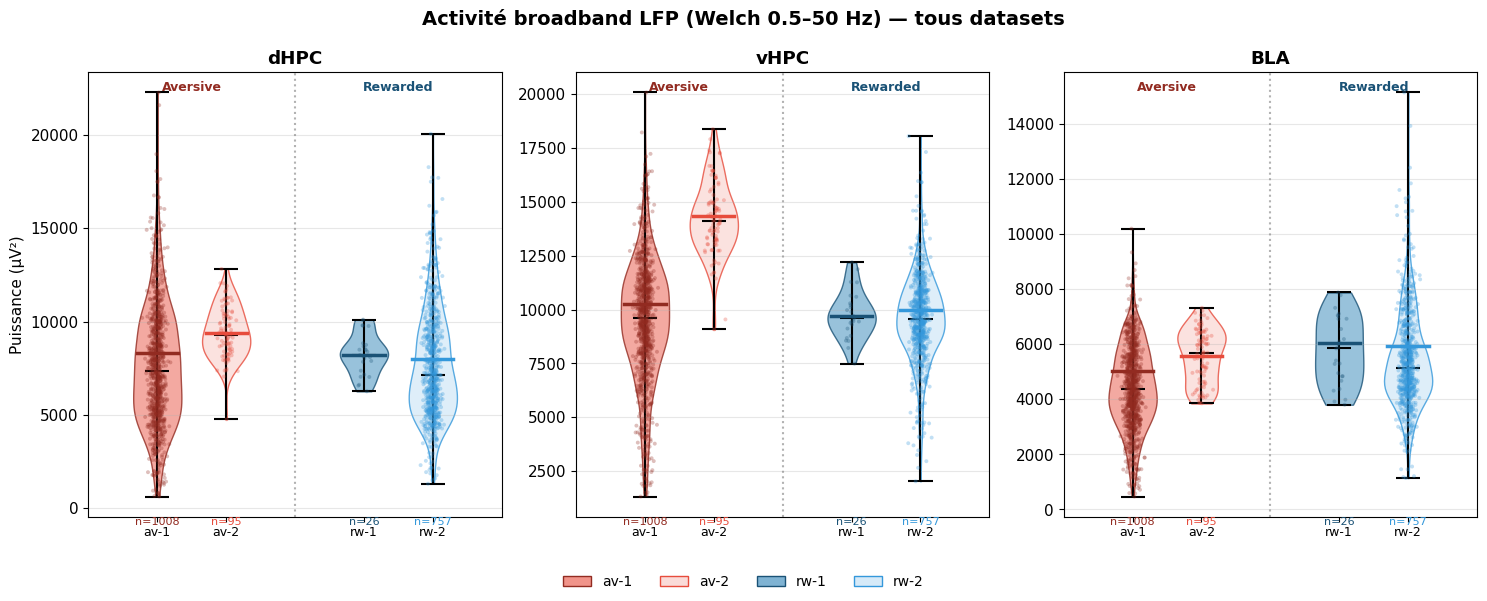

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=False)
fig.suptitle('Activité broadband LFP (Welch 0.5–50 Hz) — tous datasets', fontsize=14, fontweight='bold')

# positions : av-1=1, av-2=2, [gap], rw-1=4, rw-2=5
POSITIONS = {'av-1': 1, 'av-2': 2, 'rw-1': 4, 'rw-2': 5}
XTICKS    = [1, 2, 4, 5]
XLABELS   = ['av-1', 'av-2', 'rw-1', 'rw-2']

for ax, reg_name in zip(axes, REGION_NAMES):
    data_list = []
    positions = []
    for ds in DATASET_NAMES:
        pows, wts, _ = BROADBAND[ds][reg_name]
        v, w = get_valid(pows, wts)
        data_list.append(v)
        positions.append(POSITIONS[ds])

    # Violin
    vp = ax.violinplot(data_list, positions=positions, showmedians=True, widths=0.7)
    for i, (body, ds) in enumerate(zip(vp['bodies'], DATASET_NAMES)):
        body.set_facecolor(FACE_COLORS[ds])
        body.set_edgecolor(COLORS[ds])
        body.set_alpha(0.8)
    for part in ['cmedians', 'cbars', 'cmins', 'cmaxes']:
        vp[part].set_color('black')
        vp[part].set_linewidth(1.5)

    # Points individuels (jitter)
    rng = np.random.default_rng(42)
    for ds, pos in POSITIONS.items():
        pows, wts, _ = BROADBAND[ds][reg_name]
        v, _ = get_valid(pows, wts)
        jitter = rng.normal(0, 0.06, len(v))
        ax.scatter(pos + jitter, v, alpha=0.3, s=8, color=COLORS[ds], edgecolors='none', zorder=2)

    # Ligne de moyenne pondérée
    for ds, pos in POSITIONS.items():
        pows, wts, _ = BROADBAND[ds][reg_name]
        wm, _ = weighted_mean_std(pows, wts)
        if np.isfinite(wm):
            ax.plot([pos - 0.3, pos + 0.3], [wm, wm], '-', color=COLORS[ds], lw=2.5, zorder=3)

    # Annotation n
    for ds, pos in POSITIONS.items():
        pows, wts, _ = BROADBAND[ds][reg_name]
        v, _ = get_valid(pows, wts)
        ax.text(pos, ax.get_ylim()[0] if ax.get_ylim()[0] != 0 else -0.05 * max([d.max() if len(d) > 0 else 0 for d in data_list if len(d) > 0] or [1]),
                f'n={len(v)}', ha='center', va='top', fontsize=8, color=COLORS[ds])

    # Séparateur conditionnel
    ax.axvline(3, color='gray', linestyle=':', lw=1.5, alpha=0.6)
    ax.set_xticks(XTICKS)
    ax.set_xticklabels(XLABELS, fontsize=9)
    ax.set_title(reg_name, fontweight='bold')
    ax.set_ylabel('Puissance (µV²)' if reg_name == 'dHPC' else '')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xlim(0, 6)

    # Étiquettes de condition
    y_top = ax.get_ylim()[1]
    ax.text(1.5, y_top * 0.98, 'Aversive', ha='center', va='top', fontsize=9, color='#922b21', fontweight='bold')
    ax.text(4.5, y_top * 0.98, 'Rewarded', ha='center', va='top', fontsize=9, color='#1a5276', fontweight='bold')

# Légende
patches = [mpatches.Patch(facecolor=FACE_COLORS[ds], edgecolor=COLORS[ds], label=ds) for ds in DATASET_NAMES]
fig.legend(handles=patches, loc='lower center', ncol=4, frameon=False, fontsize=10)
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig('figs/H1_broadband_all_datasets.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4b. Δ broadband Stage II − wmean(Stage I)

Pour chaque epoch de Stage II, on calcule :

$$\delta_j = P_j^{(\text{StageII})} - \bar{P}_w^{(\text{StageI})}$$

où $\bar{P}_w^{(\text{StageI})}$ est la moyenne pondérée broadband du Stage I du même fichier.
Un $\delta > 0$ indique une augmentation de la puissance totale du Stage I vers le Stage II.

In [6]:
def compute_broadband_delta(ds_name, stage_pair, reg_name):
    """
    δ_j = broadband_j(StageII) − weighted_mean(broadband, StageI).
    Retourne (deltas, weights) pour les epochs StageII valides.
    """
    st1, st2 = stage_pair
    pows, wts, labs = BROADBAND[ds_name][reg_name]
    v1, w1 = get_valid(pows[labs == st1], wts[labs == st1])
    v2, w2 = get_valid(pows[labs == st2], wts[labs == st2])
    if len(v1) < 2 or len(v2) < 2:
        return np.array([]), np.array([])
    mu_I = weighted_mean_std(v1, w1)[0]
    if not np.isfinite(mu_I):
        return np.array([]), np.array([])
    return v2 - mu_I, w2


def plot_broadband_delta(stage_pair, title, filename=None):
    """
    Figure 1×3 (une colonne par région).
    Chaque subplot : 4 violins [av-1 | av-2 ┆ rw-1 | rw-2]
    représentant la distribution des δ broadband (µV²).
    """
    st1, st2 = stage_pair
    POSITIONS = {'av-1': 1, 'av-2': 2, 'rw-1': 4, 'rw-2': 5}

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
    fig.suptitle(title, fontsize=14, fontweight='bold')

    for ax, reg_name in zip(axes, REGION_NAMES):
        deltas_ds, weights_ds = {}, {}
        v1_ds, v2_ds = {}, {}
        for ds in DATASET_NAMES:
            d, w = compute_broadband_delta(ds, stage_pair, reg_name)
            deltas_ds[ds], weights_ds[ds] = d, w
            pows, wts, labs = BROADBAND[ds][reg_name]
            v1_ds[ds], _ = get_valid(pows[labs == st1], wts[labs == st1])
            v2_ds[ds], _ = get_valid(pows[labs == st2], wts[labs == st2])

        data_vln = [
            deltas_ds[ds] if len(deltas_ds[ds]) > 1 else np.array([0., 0.])
            for ds in DATASET_NAMES
        ]
        positions = list(POSITIONS.values())

        vp = ax.violinplot(data_vln, positions=positions, showmedians=True, widths=0.65)
        for body, ds in zip(vp['bodies'], DATASET_NAMES):
            body.set_facecolor(FACE_COLORS[ds])
            body.set_edgecolor(COLORS[ds])
            body.set_alpha(0.82)
        for part in ['cmedians', 'cbars', 'cmins', 'cmaxes']:
            vp[part].set_color('black')
            vp[part].set_linewidth(1.2)

        rng = np.random.default_rng(42)
        for ds, pos in POSITIONS.items():
            d, w = deltas_ds[ds], weights_ds[ds]
            if len(d) == 0:
                continue
            ax.scatter(pos + rng.normal(0, 0.05, len(d)), d,
                       alpha=0.22, s=5, color=COLORS[ds], edgecolors='none', zorder=2)
            wm, _ = weighted_mean_std(d, w)
            if np.isfinite(wm):
                ax.plot([pos - 0.28, pos + 0.28], [wm, wm], '-',
                        color=COLORS[ds], lw=2.2, zorder=3)

        ax.axhline(0, color='black', lw=1.0, linestyle='--', alpha=0.5, zorder=1)
        ax.axvline(3, color='gray', linestyle=':', lw=1.2, alpha=0.5)

        ymin_ax, ymax_ax = ax.get_ylim()
        yrange = max(ymax_ax - ymin_ax, 1e-9)

        for ds, pos in POSITIONS.items():
            v1, v2 = v1_ds[ds], v2_ds[ds]
            d, w   = deltas_ds[ds], weights_ds[ds]
            if len(v1) >= 3 and len(v2) >= 3:
                _, p = stats.mannwhitneyu(v1, v2, alternative='two-sided')
                wm = weighted_mean_std(d, w)[0]
                arrow = '↑' if (np.isfinite(wm) and wm >= 0) else '↓'
                lbl = f'{arrow} {sig_label(p)}'
                ax.text(pos, ymax_ax - 0.01 * yrange, lbl,
                        ha='center', va='top', fontsize=7.5, color=COLORS[ds], fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.15', facecolor='white',
                                  alpha=0.85, edgecolor=COLORS[ds], lw=0.6))

        av_d = np.concatenate([deltas_ds[ds] for ds in ['av-1', 'av-2'] if len(deltas_ds[ds]) > 0])
        rw_d = np.concatenate([deltas_ds[ds] for ds in ['rw-1', 'rw-2'] if len(deltas_ds[ds]) > 0])
        if len(av_d) >= 3 and len(rw_d) >= 3:
            _, p_cond = stats.mannwhitneyu(av_d, rw_d, alternative='two-sided')
            ax.text(3.0, ymin_ax + 0.03 * yrange,
                    f'AV≠RW: {sig_label(p_cond)}',
                    ha='center', va='bottom', fontsize=7, color='#6c3483',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='#f8f0ff',
                              alpha=0.9, edgecolor='#6c3483', lw=0.6))

        ax.set_xticks([1, 2, 4, 5])
        ax.set_xticklabels(DATASET_NAMES, fontsize=8)
        ax.set_xlim(0, 6)
        ax.set_title(reg_name, fontweight='bold')
        ax.set_ylabel('Δ puissance broadband (µV²)' if reg_name == REGION_NAMES[0] else '')
        ax.grid(True, alpha=0.2, axis='y')

        ymax2 = ax.get_ylim()[1]
        ax.text(1.5, ymax2, 'Aversive', ha='center', va='bottom',
                fontsize=7.5, color='#922b21', fontstyle='italic')
        ax.text(4.5, ymax2, 'Rewarded', ha='center', va='bottom',
                fontsize=7.5, color='#1a5276', fontstyle='italic')

    patches = [mpatches.Patch(facecolor=FACE_COLORS[ds], edgecolor=COLORS[ds], label=ds)
               for ds in DATASET_NAMES]
    fig.legend(handles=patches, loc='lower center', ncol=4, frameon=False, fontsize=9)
    plt.tight_layout(rect=[0, 0.07, 1, 1])
    if filename:
        plt.savefig(f'figs/{filename}', dpi=150, bbox_inches='tight')
    plt.show()


print('Fonctions compute_broadband_delta et plot_broadband_delta définies.')

Fonctions compute_broadband_delta et plot_broadband_delta définies.


### 4b-i. NREM I → NREM II

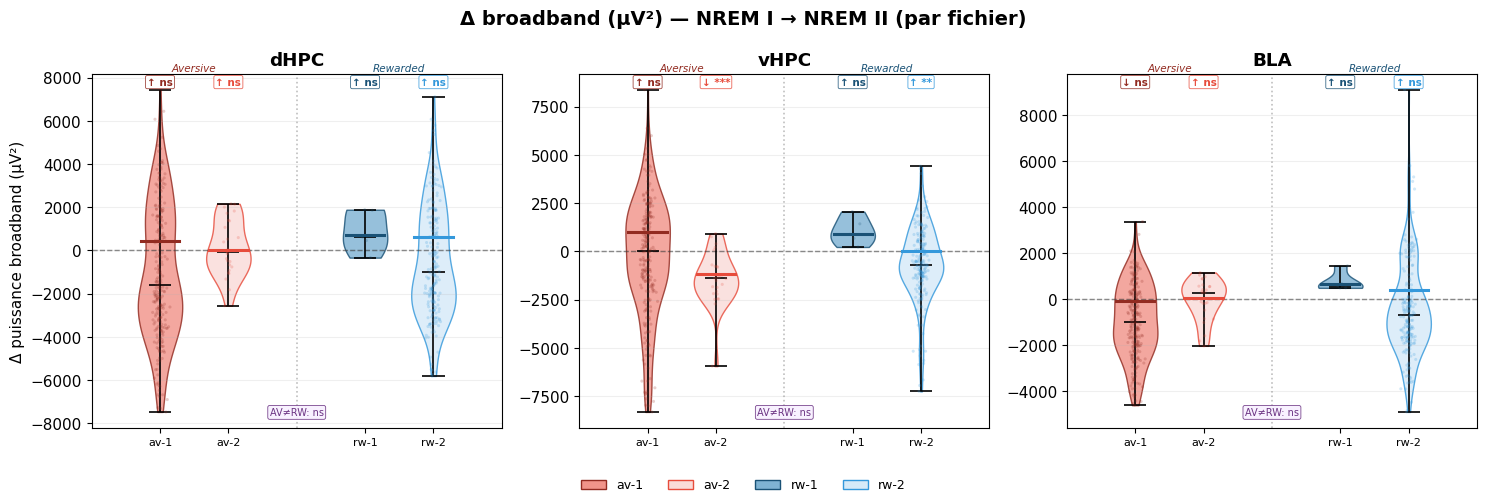

In [7]:
plot_broadband_delta(
    stage_pair=('NREM I', 'NREM II'),
    title='Δ broadband (µV²) — NREM I → NREM II (par fichier)',
    filename='H1_NREM_broadband_delta.png'
)

### 4b-ii. REM I → REM II

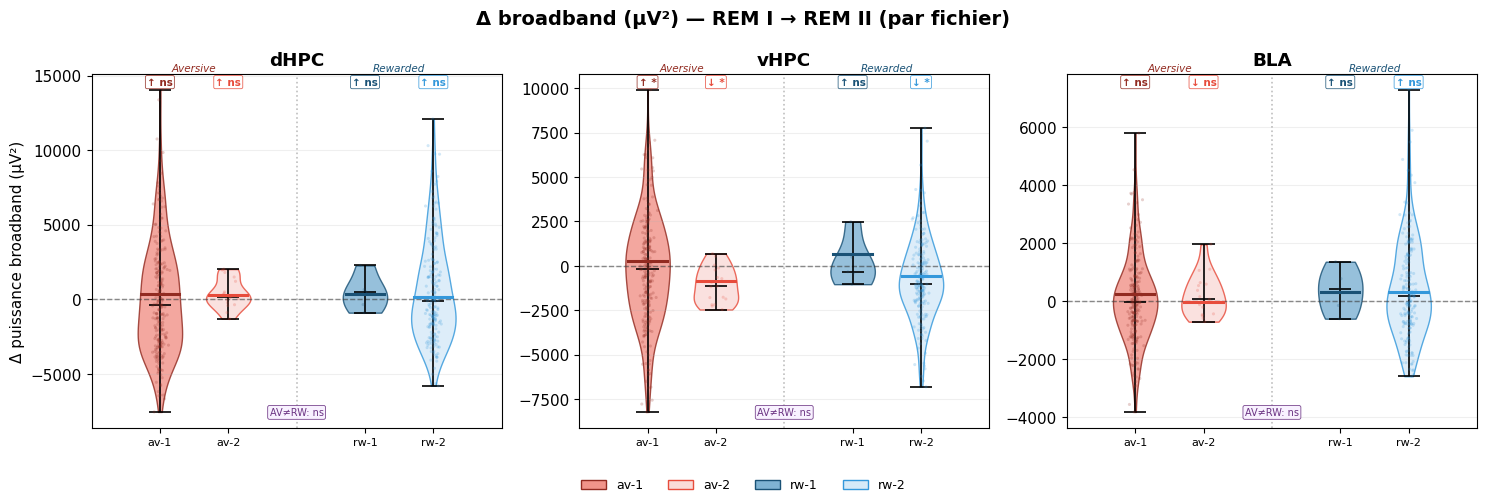

In [8]:
plot_broadband_delta(
    stage_pair=('REM I', 'REM II'),
    title='Δ broadband (µV²) — REM I → REM II (par fichier)',
    filename='H1_REM_broadband_delta.png'
)

---
## 5. Calcul des puissances relatives par bande

$$P_{\text{rel}}(\text{bande}) = \frac{\sum_{f \in \text{bande}} \hat{S}(f)}{\sum_{f=0.5}^{50} \hat{S}(f)}$$

In [9]:
def compute_band_powers_per_dataset(df, regions=REGIONS, bands=FREQ_BANDS,
                                     fs=FS, min_samples=MIN_SAMPLES):
    """
    Calcule la puissance relative par bande et par région pour chaque epoch.

    Retourne un dict {(region_name, band_name): (powers, weights, labels)}.
    """
    result = {}
    for reg_name, col in regions.items():
        for band_name, (f_low, f_high) in bands.items():
            powers  = []
            weights = []
            labels  = []
            for _, row in df.iterrows():
                lfp = np.asarray(row[col], dtype=float)
                w   = float(row['t_end'] - row['t_start'])
                if len(lfp) < min_samples:
                    powers.append(np.nan)
                else:
                    powers.append(compute_relative_band_power(lfp, fs, f_low, f_high))
                weights.append(w)
                labels.append(row['epoch_label'])
            result[(reg_name, band_name)] = (
                np.array(powers, dtype=float),
                np.array(weights, dtype=float),
                np.array(labels),
            )
    return result

print('Calcul des puissances relatives par bande...')
BAND_POWERS = {}
for name, df in DATASETS.items():
    print(f'  {name}...')
    BAND_POWERS[name] = compute_band_powers_per_dataset(df)

print('Calcul terminé.')

Calcul des puissances relatives par bande...
  av-1...
  av-2...
  rw-1...
  rw-2...
Calcul terminé.


---
## 6. Distributions des Δ = Stage II − wmean(Stage I)

Pour chaque subplot (région × bande), **4 violins indépendants** — un par fichier :

```
[av-1 Δ | av-2 Δ ┆ rw-1 Δ | rw-2 Δ]
```

**Calcul du delta par epoch** : pour chaque epoch de Stage II d'un fichier donné,
on soustrait la moyenne pondérée des epochs de Stage I du même fichier :

$$\delta_j = x_j^{(\text{II})} - \bar{x}_w^{(\text{I})}$$

- **y = 0** : pas de changement entre les phases
- **↑ / ↓** = direction du shift, p-value MWU bilatéral (Stage I vs Stage II)  
- **AV≠RW** = test MWU entre la distribution des Δ aversifs (av-1+av-2) vs rewarded (rw-1+rw-2)


In [10]:
def compute_delta_distribution(ds_name, stage_pair, reg_name, band_name):
    """
    δ_j = power_j^(StageII) − weighted_mean(Stage I), pour chaque epoch de Stage II.

    Paramètres
    ----------
    ds_name    : str  — identifiant du dataset ('av-1', 'av-2', 'rw-1', 'rw-2')
    stage_pair : tuple of str — (st1, st2)
    reg_name   : str  — région ('dHPC', 'vHPC', 'BLA')
    band_name  : str  — bande ('low', 'theta', 'beta', 'high')

    Retourne
    --------
    deltas  : np.ndarray  — δ_j pour chaque epoch de Stage II valide
    weights : np.ndarray  — durées correspondantes (pour pondération)
    """
    st1, st2 = stage_pair
    pows, wts, labs = BAND_POWERS[ds_name][(reg_name, band_name)]
    v1, w1 = get_valid(pows[labs == st1], wts[labs == st1])
    v2, w2 = get_valid(pows[labs == st2], wts[labs == st2])
    if len(v1) < 2 or len(v2) < 2:
        return np.array([]), np.array([])
    mu_I = weighted_mean_std(v1, w1)[0]
    if not np.isfinite(mu_I):
        return np.array([]), np.array([])
    return v2 - mu_I, w2


def plot_stage_delta(stage_pair, title, filename=None):
    """
    Figure 3×4 (régions × bandes) — distributions des deltas par fichier.

    Chaque subplot : 4 violins [av-1 | av-2 ┆ rw-1 | rw-2].
    Chaque violin = distribution de δ_j = power(StageII) − wmean(StageI)
    pour ce fichier. La ligne y=0 représente l'absence de changement.

    Annotations :
      - ↑/↓ + sig_label(p_MWU)  : direction et significativité du shift (I vs II)
      - AV≠RW : test MWU entre deltas aversifs et deltas rewarded (poolés)
    """
    st1, st2 = stage_pair
    POSITIONS = {'av-1': 1, 'av-2': 2, 'rw-1': 4, 'rw-2': 5}
    n_reg  = len(REGION_NAMES)
    n_band = len(BAND_NAMES)

    fig, axes = plt.subplots(n_reg, n_band, figsize=(5 * n_band, 4.5 * n_reg))
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)

    for ri, reg_name in enumerate(REGION_NAMES):
        for bi, band_name in enumerate(BAND_NAMES):
            ax = axes[ri][bi]
            f_low, f_high = FREQ_BANDS[band_name]

            # Delta distributions et valeurs brutes pour MWU
            deltas_ds, weights_ds, v1_ds, v2_ds = {}, {}, {}, {}
            for ds in DATASET_NAMES:
                d, w = compute_delta_distribution(ds, stage_pair, reg_name, band_name)
                deltas_ds[ds], weights_ds[ds] = d, w
                pows, wts, labs = BAND_POWERS[ds][(reg_name, band_name)]
                v1_ds[ds], _ = get_valid(pows[labs == st1], wts[labs == st1])
                v2_ds[ds], _ = get_valid(pows[labs == st2], wts[labs == st2])

            positions = list(POSITIONS.values())
            data_vln = [
                deltas_ds[ds] if len(deltas_ds[ds]) > 1 else np.array([0., 0.])
                for ds in DATASET_NAMES
            ]

            # Violins
            vp = ax.violinplot(data_vln, positions=positions, showmedians=True, widths=0.65)
            for body, ds in zip(vp['bodies'], DATASET_NAMES):
                body.set_facecolor(FACE_COLORS[ds])
                body.set_edgecolor(COLORS[ds])
                body.set_alpha(0.82)
            for part in ['cmedians', 'cbars', 'cmins', 'cmaxes']:
                vp[part].set_color('black'); vp[part].set_linewidth(1.2)

            # Jitter + ligne moyenne pondérée
            rng = np.random.default_rng(42)
            for ds, pos in POSITIONS.items():
                d, w = deltas_ds[ds], weights_ds[ds]
                if len(d) == 0:
                    continue
                ax.scatter(pos + rng.normal(0, 0.05, len(d)), d,
                           alpha=0.22, s=5, color=COLORS[ds], edgecolors='none', zorder=2)
                wm, _ = weighted_mean_std(d, w)
                if np.isfinite(wm):
                    ax.plot([pos - 0.28, pos + 0.28], [wm, wm], '-',
                            color=COLORS[ds], lw=2.2, zorder=3)

            # Ligne y=0 (pas de changement)
            ax.axhline(0, color='black', lw=1.0, linestyle='--', alpha=0.5, zorder=1)
            ax.axvline(3, color='gray', linestyle=':', lw=1.2, alpha=0.5)

            ymin, ymax_ax = ax.get_ylim()
            yrange = max(ymax_ax - ymin, 1e-9)

            # Annotation : p-value MWU + direction par fichier
            for ds, pos in POSITIONS.items():
                v1, v2 = v1_ds[ds], v2_ds[ds]
                d, w   = deltas_ds[ds], weights_ds[ds]
                if len(v1) >= 3 and len(v2) >= 3:
                    _, p = stats.mannwhitneyu(v1, v2, alternative='two-sided')
                    wm = weighted_mean_std(d, w)[0]
                    arrow = '↑' if (np.isfinite(wm) and wm >= 0) else '↓'
                    lbl = f'{arrow} {sig_label(p)}'
                    ax.text(pos, ymax_ax - 0.01 * yrange, lbl,
                            ha='center', va='top', fontsize=7.5, color=COLORS[ds], fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.15', facecolor='white',
                                      alpha=0.85, edgecolor=COLORS[ds], lw=0.6))

            # Test inter-conditions : Δ aversif vs Δ rewarded (MWU, poolé)
            av_d = np.concatenate([deltas_ds[ds] for ds in ['av-1', 'av-2']
                                   if len(deltas_ds[ds]) > 0])
            rw_d = np.concatenate([deltas_ds[ds] for ds in ['rw-1', 'rw-2']
                                   if len(deltas_ds[ds]) > 0])
            if len(av_d) >= 3 and len(rw_d) >= 3:
                _, p_cond = stats.mannwhitneyu(av_d, rw_d, alternative='two-sided')
                ax.text(3.0, ymin + 0.03 * yrange,
                        f'AV≠RW: {sig_label(p_cond)}',
                        ha='center', va='bottom', fontsize=7, color='#6c3483',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='#f8f0ff',
                                  alpha=0.9, edgecolor='#6c3483', lw=0.6))

            ax.set_xticks([1, 2, 4, 5])
            ax.set_xticklabels(DATASET_NAMES, fontsize=8)
            ax.set_xlim(0, 6)
            ax.grid(True, alpha=0.2, axis='y')

            if ri == 0:
                ax.set_title(f'{band_name}\n({f_low}–{f_high} Hz)', fontweight='bold', fontsize=10)
            if bi == 0:
                ax.set_ylabel(f'{reg_name}\nΔ puissance relative', fontsize=9)

            ymax2 = ax.get_ylim()[1]
            ax.text(1.5, ymax2, 'Aversive', ha='center', va='bottom',
                    fontsize=7.5, color='#922b21', fontstyle='italic')
            ax.text(4.5, ymax2, 'Rewarded', ha='center', va='bottom',
                    fontsize=7.5, color='#1a5276', fontstyle='italic')

    patches = [mpatches.Patch(facecolor=FACE_COLORS[ds], edgecolor=COLORS[ds], label=ds)
               for ds in DATASET_NAMES]
    fig.legend(handles=patches, loc='lower center', ncol=4, frameon=False, fontsize=9)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    if filename:
        plt.savefig(f'figs/{filename}', dpi=150, bbox_inches='tight')
    plt.show()


def plot_delta_bars(stage_pair, title, filename=None):
    """
    Barplot résumé : 4 barres par bande (une par fichier) montrant weighted_mean(Δ).
    Une colonne par région.
    """
    st1, st2 = stage_pair
    fig, axes = plt.subplots(1, len(REGION_NAMES),
                              figsize=(5 * len(REGION_NAMES), 5), sharey=False)
    fig.suptitle(title, fontsize=13, fontweight='bold')

    x = np.arange(len(BAND_NAMES))
    w_bar = 0.18
    offsets = np.array([-1.5, -0.5, 0.5, 1.5]) * w_bar

    for ax, reg_name in zip(axes, REGION_NAMES):
        for di, ds in enumerate(DATASET_NAMES):
            wmeans = []
            for band_name in BAND_NAMES:
                d, w = compute_delta_distribution(ds, stage_pair, reg_name, band_name)
                wm = weighted_mean_std(d, w)[0] if len(d) >= 2 else np.nan
                wmeans.append(wm)
            ax.bar(x + offsets[di], wmeans, w_bar,
                   color=FACE_COLORS[ds], edgecolor=COLORS[ds], linewidth=1.5, label=ds)

        ax.axhline(0, color='black', lw=1.2)
        ax.set_xticks(x)
        ax.set_xticklabels(BAND_NAMES, fontsize=10)
        ax.set_title(reg_name, fontweight='bold')
        if reg_name == REGION_NAMES[0]:
            ax.set_ylabel(f'Δ moyen pondéré\n({st2} − wmean({st1}))', fontsize=10)
        ax.grid(True, alpha=0.2, axis='y')
        ax.legend(fontsize=8, framealpha=0.8, ncol=2)

    plt.tight_layout()
    if filename:
        plt.savefig(f'figs/{filename}', dpi=150, bbox_inches='tight')
    plt.show()


print('Fonctions compute_delta_distribution, plot_stage_delta, plot_delta_bars définies.')


Fonctions compute_delta_distribution, plot_stage_delta, plot_delta_bars définies.


### 6a. NREM I → NREM II

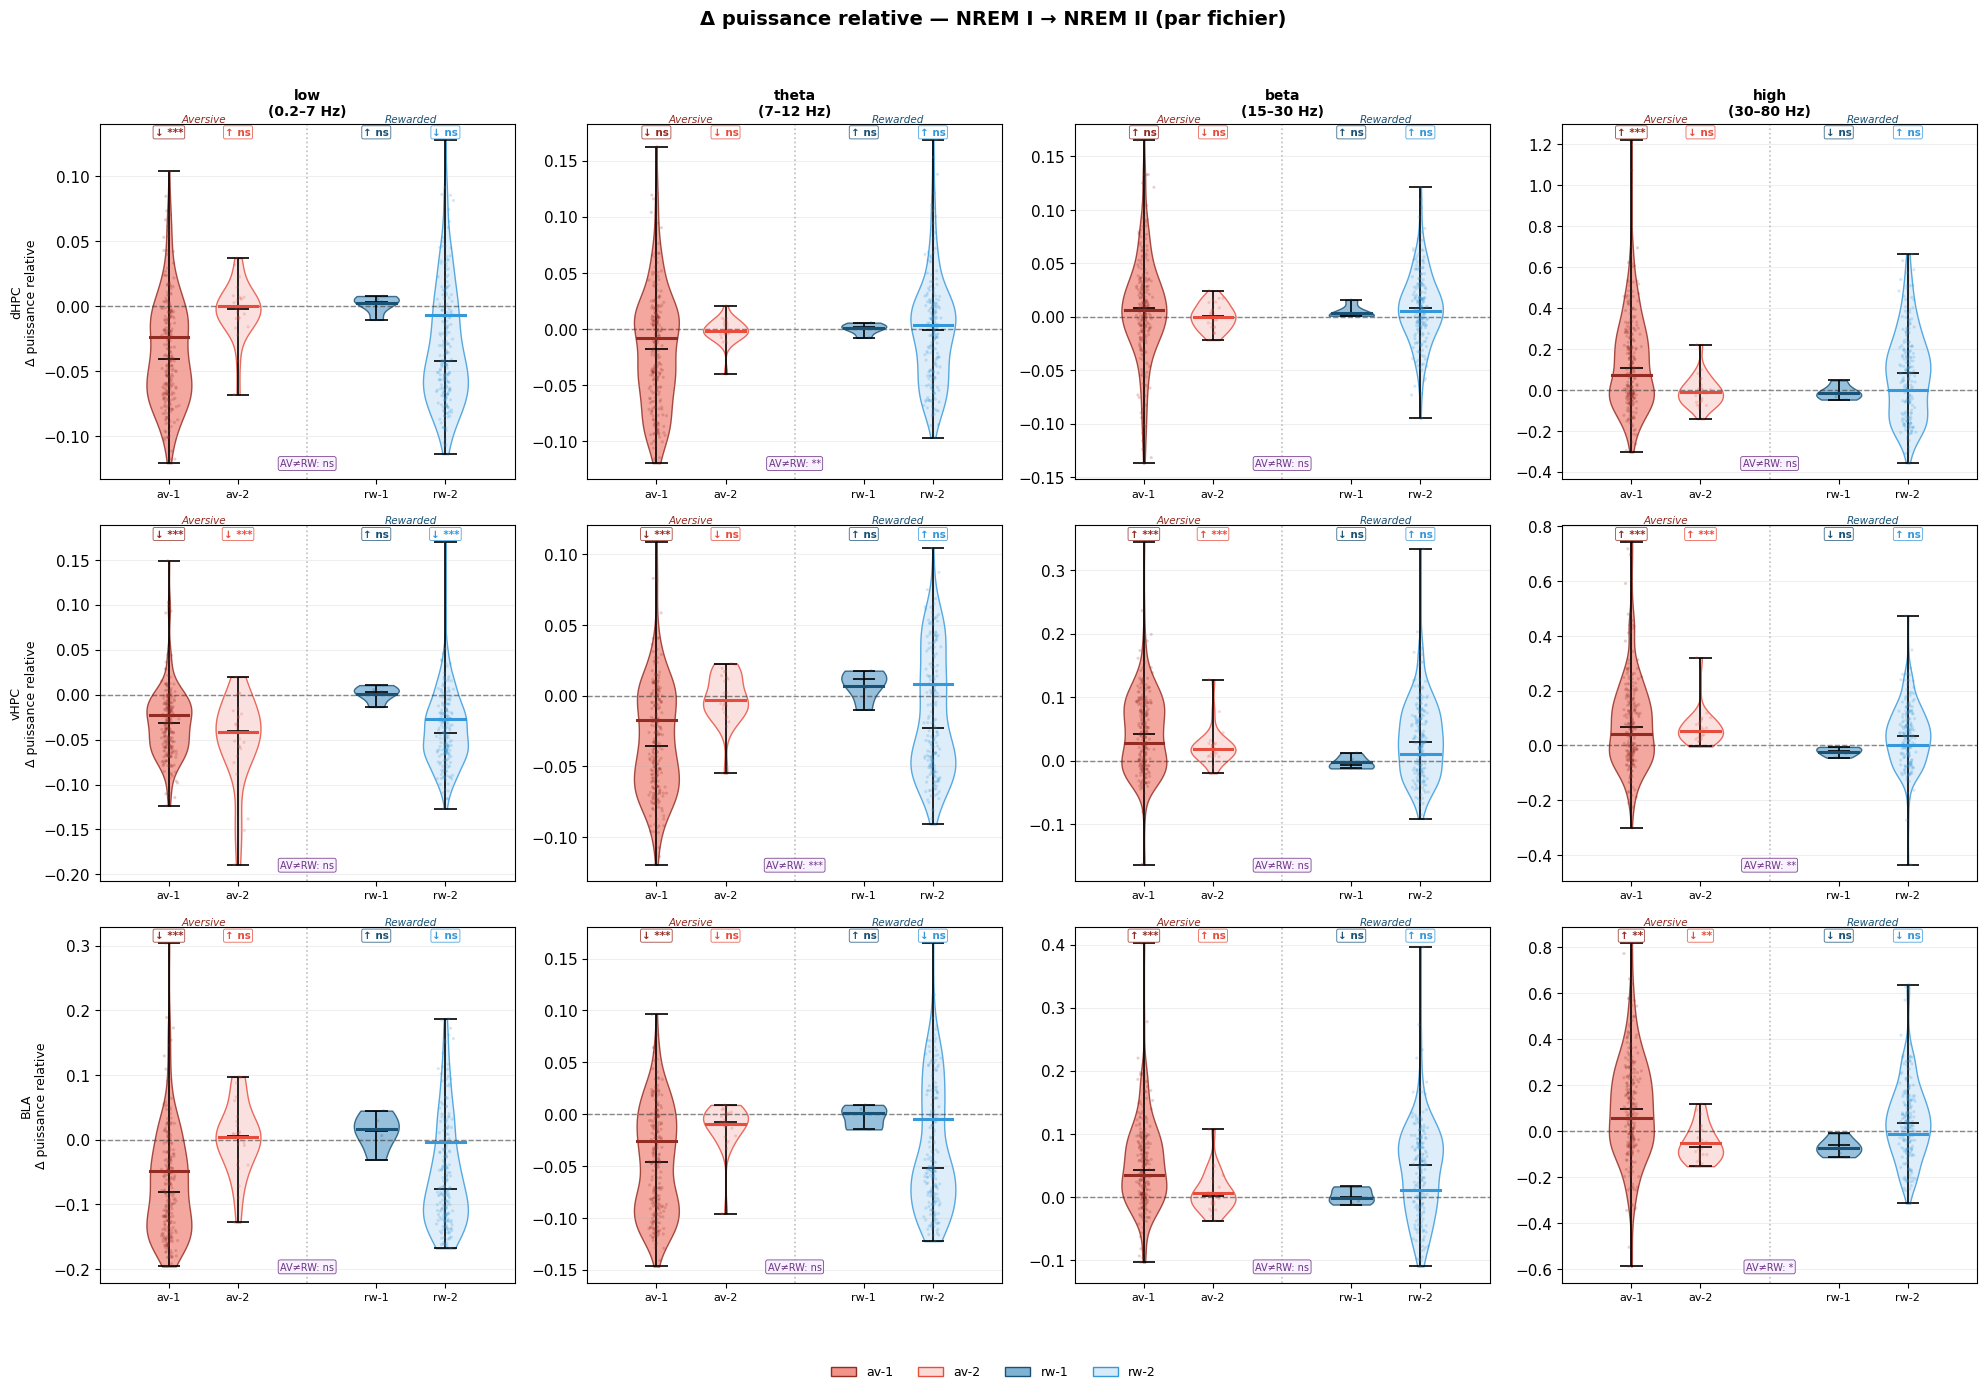

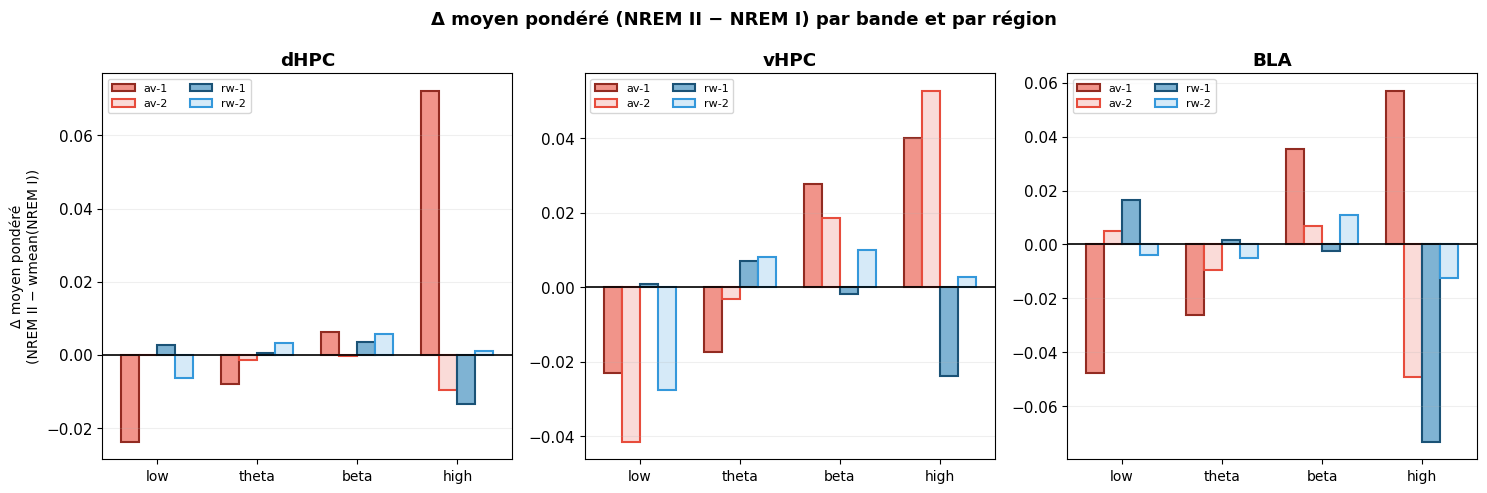

In [11]:
plot_stage_delta(
    stage_pair=('NREM I', 'NREM II'),
    title='Δ puissance relative — NREM I → NREM II (par fichier)',
    filename='H1_NREM_delta_violin.png',
)

plot_delta_bars(
    stage_pair=('NREM I', 'NREM II'),
    title='Δ moyen pondéré (NREM II − NREM I) par bande et par région',
    filename='H1_NREM_delta_bars.png',
)

### 6b. REM I → REM II

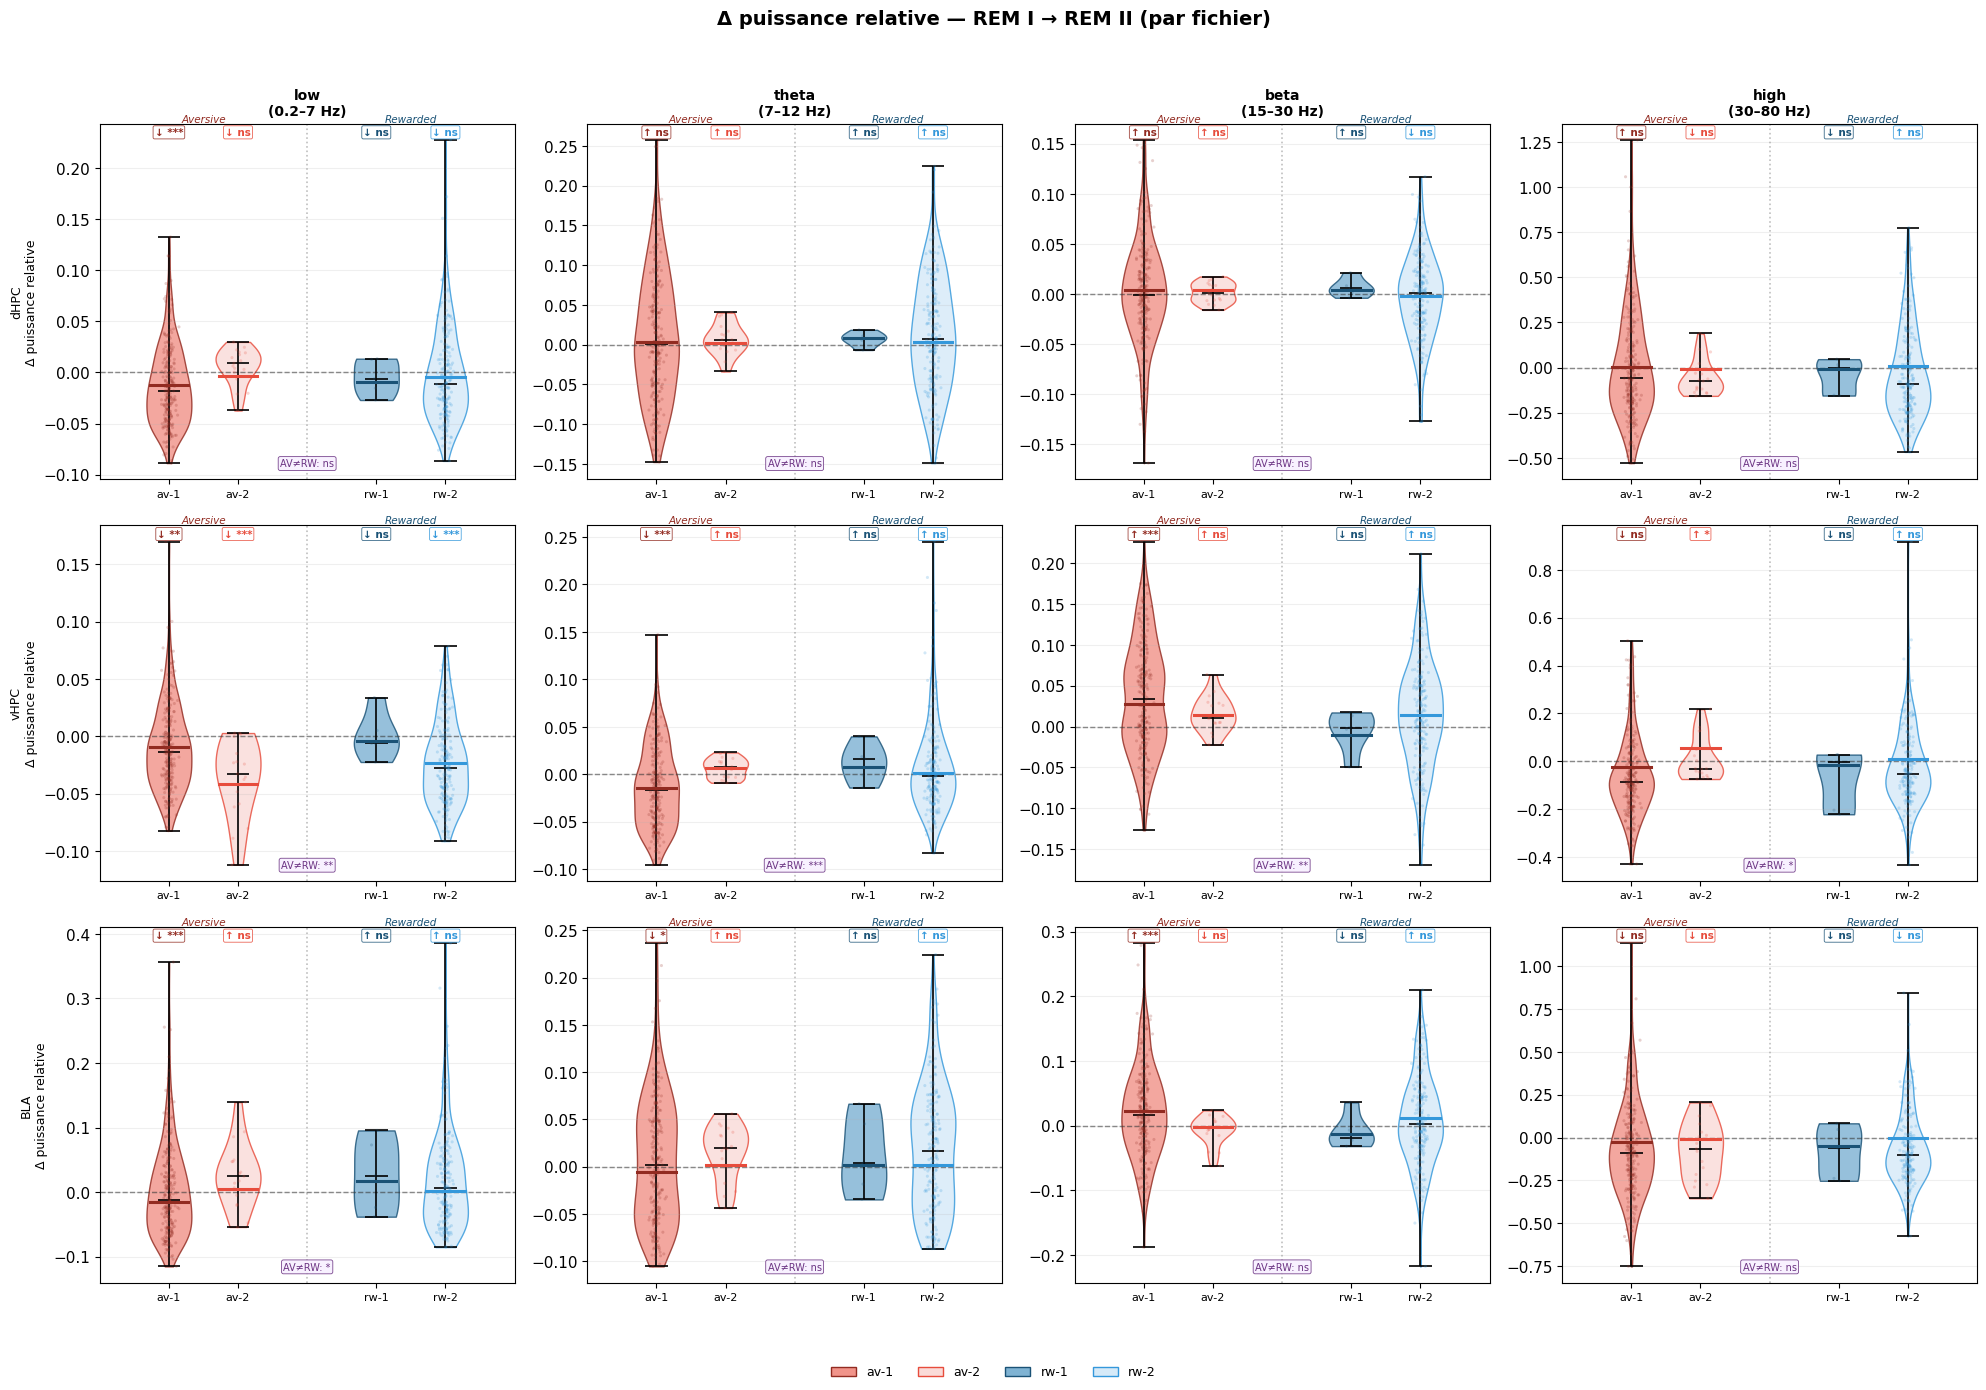

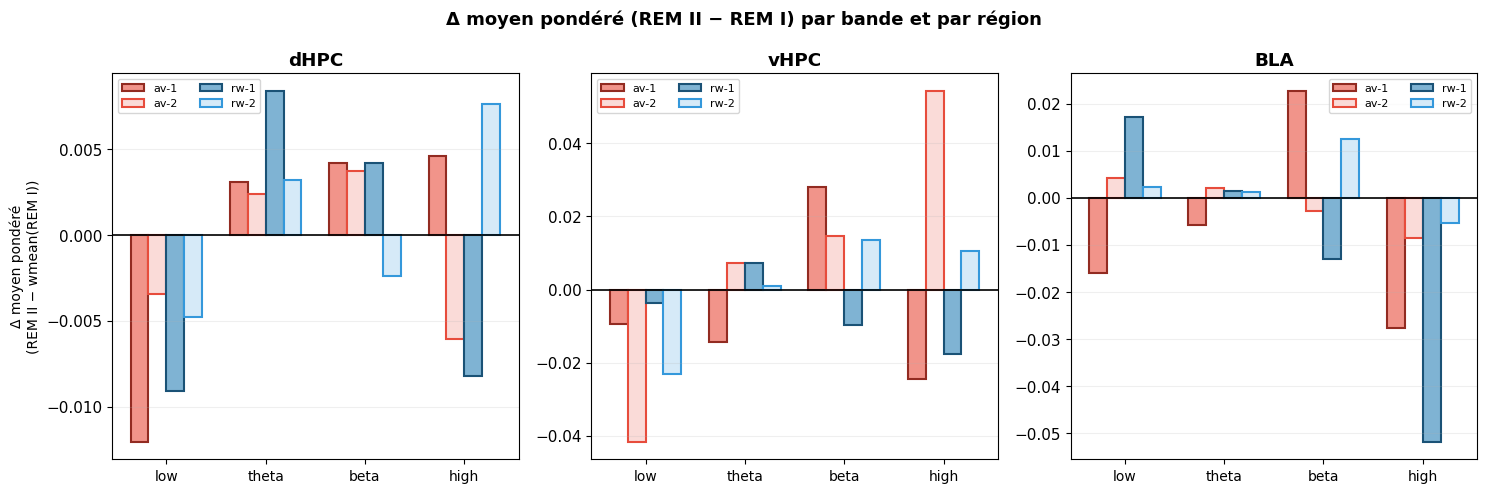

In [12]:
plot_stage_delta(
    stage_pair=('REM I', 'REM II'),
    title='Δ puissance relative — REM I → REM II (par fichier)',
    filename='H1_REM_delta_violin.png',
)

plot_delta_bars(
    stage_pair=('REM I', 'REM II'),
    title='Δ moyen pondéré (REM II − REM I) par bande et par région',
    filename='H1_REM_delta_bars.png',
)

---
## 8. Tests statistiques détaillés

### 8a. MWU bilatéral + test de permutation pondéré (NREM I vs NREM II)

Pour chaque dataset, région, bande :
- **H₀** : la puissance relative de NREM I et NREM II provient de la même distribution
- **Test** : Mann-Whitney U bilatéral (scipy) **et** test de permutation pondéré (10 000 itérations)
- **Pondération** : durée de l'epoch (les epochs longs ont plus de poids)
- **Taille d'effet** : r = 1 − 2U/(n₁·n₂), η² = r²

In [13]:
def run_stage_tests(dataset_name, stage_pair, regions=REGIONS, bands=FREQ_BANDS):
    """
    MWU bilatéral + test de permutation pondéré pour un dataset et une paire de stages.
    Retourne un DataFrame de résultats.
    """
    st1, st2 = stage_pair
    rows = []
    for reg_name in regions:
        for band_name in bands:
            pows, wts, labs = BAND_POWERS[dataset_name][(reg_name, band_name)]
            v1, w1 = get_valid(pows[labs == st1], wts[labs == st1])
            v2, w2 = get_valid(pows[labs == st2], wts[labs == st2])
            n1, n2 = len(v1), len(v2)

            if n1 >= 3 and n2 >= 3:
                u_stat, p_mwu = stats.mannwhitneyu(v1, v2, alternative='two-sided')
                r    = 1 - 2 * u_stat / (n1 * n2)
                eta2 = r ** 2
                _, p_perm, _, _ = weighted_permutation_test(v1, w1, v2, w2, n_perm=N_PERM)
                wm1, ws1 = weighted_mean_std(v1, w1)
                wm2, ws2 = weighted_mean_std(v2, w2)
            else:
                u_stat = p_mwu = r = eta2 = p_perm = np.nan
                wm1 = ws1 = wm2 = ws2 = np.nan

            rows.append({
                'dataset':    dataset_name,
                'stage_1':   st1,
                'stage_2':   st2,
                'region':    reg_name,
                'band':      band_name,
                'n_stage1':  n1,
                'n_stage2':  n2,
                'wmean_1':   wm1,
                'wmean_2':   wm2,
                'U':         u_stat,
                'p_mwu':     p_mwu,
                'p_perm':    p_perm,
                'sig_mwu':   sig_label(p_mwu),
                'sig_perm':  sig_label(p_perm),
                'r':         r,
                'eta2':      eta2,
                'effet':     eta_sq_label(eta2),
            })
    return pd.DataFrame(rows)


print('=== NREM I vs NREM II ===')
dfs_nrem = []
for ds in DATASET_NAMES:
    df_res = run_stage_tests(ds, ('NREM I', 'NREM II'))
    dfs_nrem.append(df_res)

df_nrem = pd.concat(dfs_nrem, ignore_index=True)

# Affichage synthétique
display(df_nrem[['dataset','region','band','n_stage1','n_stage2',
                  'wmean_1','wmean_2','p_mwu','sig_mwu','p_perm','sig_perm','eta2','effet']]
        .round(4))

=== NREM I vs NREM II ===


,dataset,region,band,n_stage1,n_stage2,wmean_1,wmean_2,p_mwu,sig_mwu,p_perm,sig_perm,eta2,effet
0,av-1,dHPC,low,263,246,0.1475,0.1237,0.0000,***,0.0000,***,0.0437,petit
1,av-1,dHPC,theta,263,246,0.1495,0.1416,0.2417,ns,0.0326,*,0.0036,négligeable
2,av-1,dHPC,beta,263,246,0.3294,0.3356,0.4973,ns,0.0413,*,0.0012,négligeable
3,av-1,dHPC,high,263,246,0.7725,0.8446,0.0000,***,0.0003,***,0.0489,petit
4,av-1,vHPC,low,263,246,0.1456,0.1225,0.0000,***,0.0000,***,0.0914,moyen
5,av-1,vHPC,theta,263,246,0.1316,0.1142,0.0000,***,0.0000,***,0.0788,moyen
6,av-1,vHPC,beta,263,246,0.3357,0.3634,0.0000,***,0.0000,***,0.0758,moyen
7,av-1,vHPC,high,263,246,0.8718,0.9119,0.0003,***,0.0006,***,0.0341,petit
8,av-1,BLA,low,263,246,0.2192,0.1714,0.0001,***,0.0000,***,0.0406,petit
9,av-1,BLA,theta,263,246,0.1527,0.1267,0.0000,***,0.0000,***,0.0646,moyen


In [14]:
print('=== REM I vs REM II ===')
dfs_rem = []
for ds in DATASET_NAMES:
    df_res = run_stage_tests(ds, ('REM I', 'REM II'))
    dfs_rem.append(df_res)

df_rem = pd.concat(dfs_rem, ignore_index=True)

display(df_rem[['dataset','region','band','n_stage1','n_stage2',
                 'wmean_1','wmean_2','p_mwu','sig_mwu','p_perm','sig_perm','eta2','effet']]
        .round(4))

=== REM I vs REM II ===


,dataset,region,band,n_stage1,n_stage2,wmean_1,wmean_2,p_mwu,sig_mwu,p_perm,sig_perm,eta2,effet
0,av-1,dHPC,low,257,242,0.1094,0.0973,0.0000,***,0.0011,**,0.0524,petit
1,av-1,dHPC,theta,257,242,0.1695,0.1726,0.9122,ns,0.6276,ns,0.0000,négligeable
2,av-1,dHPC,beta,257,242,0.3268,0.3310,0.4581,ns,0.2276,ns,0.0015,négligeable
3,av-1,dHPC,high,257,242,0.8346,0.8392,0.3352,ns,0.8613,ns,0.0025,négligeable
4,av-1,vHPC,low,257,242,0.1213,0.1118,0.0013,**,0.0144,*,0.0278,petit
5,av-1,vHPC,theta,257,242,0.1206,0.1062,0.0003,***,0.0000,***,0.0358,petit
6,av-1,vHPC,beta,257,242,0.3463,0.3743,0.0000,***,0.0000,***,0.0739,moyen
7,av-1,vHPC,high,257,242,1.0043,0.9798,0.4981,ns,0.3682,ns,0.0012,négligeable
8,av-1,BLA,low,257,242,0.1346,0.1186,0.0008,***,0.0585,ns,0.0302,petit
9,av-1,BLA,theta,257,242,0.1211,0.1154,0.0116,*,0.4915,ns,0.0171,petit


---
### 8b. Comparaison inter-fichiers : av-1 vs av-2

Test MWU bilatéral **entre les deux fichiers aversifs** pour vérifier si les résultats
dépendent du choix du fichier. Si les distributions sont similaires entre av-1 et av-2,
les deux datasets sont cohérents et peuvent être considérés ensemble.

In [15]:
def run_file_comparison(ds_a, ds_b, stage, regions=REGIONS, bands=FREQ_BANDS):
    """
    Compare deux datasets sur le même stage : MWU + test de permutation pondéré.
    """
    rows = []
    for reg_name in regions:
        for band_name in bands:
            pows_a, wts_a, labs_a = BAND_POWERS[ds_a][(reg_name, band_name)]
            pows_b, wts_b, labs_b = BAND_POWERS[ds_b][(reg_name, band_name)]
            va, wa = get_valid(pows_a[labs_a == stage], wts_a[labs_a == stage])
            vb, wb = get_valid(pows_b[labs_b == stage], wts_b[labs_b == stage])
            n_a, n_b = len(va), len(vb)

            if n_a >= 3 and n_b >= 3:
                u_stat, p_mwu = stats.mannwhitneyu(va, vb, alternative='two-sided')
                r    = 1 - 2 * u_stat / (n_a * n_b)
                eta2 = r ** 2
                _, p_perm, _, _ = weighted_permutation_test(va, wa, vb, wb, n_perm=N_PERM)
            else:
                u_stat = p_mwu = r = eta2 = p_perm = np.nan

            rows.append({
                'dataset_A': ds_a, 'dataset_B': ds_b,
                'stage':     stage,
                'region':    reg_name,
                'band':      band_name,
                'n_A': n_a, 'n_B': n_b,
                'U':       u_stat,
                'p_mwu':   p_mwu,
                'p_perm':  p_perm,
                'sig_mwu': sig_label(p_mwu),
                'sig_perm': sig_label(p_perm),
                'r':       r,
                'eta2':    eta2,
                'effet':   eta_sq_label(eta2),
            })
    return pd.DataFrame(rows)


print('=== Comparaison inter-fichiers : av-1 vs av-2 ===')
dfs_fc = []
for stage in ['NREM I', 'NREM II', 'REM I', 'REM II']:
    dfs_fc.append(run_file_comparison('av-1', 'av-2', stage))
df_file_comp_av = pd.concat(dfs_fc, ignore_index=True)

display(df_file_comp_av[['stage','region','band','n_A','n_B',
                           'p_mwu','sig_mwu','p_perm','sig_perm','eta2','effet']]
        .round(4))

=== Comparaison inter-fichiers : av-1 vs av-2 ===


,stage,region,band,n_A,n_B,p_mwu,sig_mwu,p_perm,sig_perm,eta2,effet
0,NREM I,dHPC,low,263,32,0.0003,***,0.2942,ns,0.1545,grand
1,NREM I,dHPC,theta,263,32,0.0074,**,0.0838,ns,0.0841,moyen
2,NREM I,dHPC,beta,263,32,0.3293,ns,1.0000,ns,0.0112,petit
3,NREM I,dHPC,high,263,32,0.0033,**,0.0269,*,0.1016,moyen
4,NREM I,vHPC,low,263,32,0.0000,***,0.0000,***,1.0000,grand
5,NREM I,vHPC,theta,263,32,0.0000,***,0.0013,**,0.3011,grand
6,NREM I,vHPC,beta,263,32,0.0000,***,0.0000,***,0.8919,grand
7,NREM I,vHPC,high,263,32,0.0000,***,0.0000,***,0.9581,grand
8,NREM I,BLA,low,263,32,0.0000,***,0.1279,ns,0.2117,grand
9,NREM I,BLA,theta,263,32,0.0026,**,0.0799,ns,0.1065,moyen


In [16]:
print('=== Comparaison inter-fichiers : rw-1 vs rw-2 ===')
dfs_fc_rw = []
for stage in ['NREM I', 'NREM II', 'REM I', 'REM II']:
    dfs_fc_rw.append(run_file_comparison('rw-1', 'rw-2', stage))
df_file_comp_rw = pd.concat(dfs_fc_rw, ignore_index=True)

display(df_file_comp_rw[['stage','region','band','n_A','n_B',
                           'p_mwu','sig_mwu','p_perm','sig_perm','eta2','effet']]
        .round(4))

=== Comparaison inter-fichiers : rw-1 vs rw-2 ===


,stage,region,band,n_A,n_B,p_mwu,sig_mwu,p_perm,sig_perm,eta2,effet
0,NREM I,dHPC,low,8,184,0.0005,***,0.4756,ns,0.4689,grand
1,NREM I,dHPC,theta,8,184,0.0127,*,0.2371,ns,0.2610,grand
2,NREM I,dHPC,beta,8,184,0.8708,ns,0.7814,ns,0.0012,négligeable
3,NREM I,dHPC,high,8,184,0.0007,***,0.1996,ns,0.4487,grand
4,NREM I,vHPC,low,8,184,0.3312,ns,0.4938,ns,0.0427,petit
5,NREM I,vHPC,theta,8,184,0.0000,***,0.1443,ns,0.6061,grand
6,NREM I,vHPC,beta,8,184,0.0117,*,0.3530,ns,0.2666,grand
7,NREM I,vHPC,high,8,184,0.1148,ns,0.5863,ns,0.1099,moyen
8,NREM I,BLA,low,8,184,0.0000,***,0.1339,ns,0.7281,grand
9,NREM I,BLA,theta,8,184,0.0001,***,0.1923,ns,0.5727,grand


---
### 8c. Broadband : statistiques descriptives et tests inter-datasets

In [17]:
bb_rows = []
for ds in DATASET_NAMES:
    for reg_name in REGION_NAMES:
        for stage in ['NREM I', 'NREM II', 'REM I', 'REM II']:
            pows, wts, labs = BROADBAND[ds][reg_name]
            v, w = get_valid(pows[labs == stage], wts[labs == stage])
            wm, ws = weighted_mean_std(v, w)
            bb_rows.append({
                'dataset':    ds,
                'condition':  COND_MAP[ds],
                'stage':      stage,
                'region':     reg_name,
                'n_epochs':   len(v),
                'wmean_µV2':  wm,
                'wstd_µV2':   ws,
                'median_µV2': float(np.median(v)) if len(v) > 0 else np.nan,
            })

df_broadband_stats = pd.DataFrame(bb_rows)
display(df_broadband_stats.round(2))

,dataset,condition,stage,region,n_epochs,wmean_µV2,wstd_µV2,median_µV2
0,av-1,Aversive,NREM I,dHPC,263,8106.28,1832.85,7217.62
1,av-1,Aversive,NREM II,dHPC,246,8557.70,2476.23,6516.57
2,av-1,Aversive,REM I,dHPC,257,8219.48,2417.86,7802.03
3,av-1,Aversive,REM II,dHPC,242,8546.84,2935.63,7805.27
4,av-1,Aversive,NREM I,vHPC,263,9827.82,1392.51,9493.80
5,av-1,Aversive,NREM II,vHPC,246,10842.70,1933.62,9849.79
6,av-1,Aversive,REM I,vHPC,257,10143.59,2040.01,9379.87
7,av-1,Aversive,REM II,vHPC,242,10423.43,2253.51,9943.39
8,av-1,Aversive,NREM I,BLA,263,5320.23,1161.52,4445.34
9,av-1,Aversive,NREM II,BLA,246,5251.86,1247.85,4334.61


---
## 9. Export Excel

3 onglets :
- **Broadband_Welch** : statistiques descriptives de la puissance broadband
- **Puissance_NREM** : tests NREM I vs NREM II (tous datasets)
- **Puissance_REM** : tests REM I vs REM II (tous datasets)
- **Comparaison_av1_av2** : tests inter-fichiers aversifs
- **Comparaison_rw1_rw2** : tests inter-fichiers rewarded

In [19]:
import os
os.makedirs('exports', exist_ok=True)

csv_map = {
    'exports/Broadband_Welch.csv': df_broadband_stats,
    'exports/Puissance_NREM.csv': df_nrem,
    'exports/Puissance_REM.csv': df_rem,
    'exports/Comparaison_av1_av2.csv': df_file_comp_av,
    'exports/Comparaison_rw1_rw2.csv': df_file_comp_rw,
}

for path, df in csv_map.items():
    df.to_csv(path, index=False)

print('Export CSV terminé :')
for path in csv_map:
    print(f' - {path}')

Export CSV terminé :
 - exports/Broadband_Welch.csv
 - exports/Puissance_NREM.csv
 - exports/Puissance_REM.csv
 - exports/Comparaison_av1_av2.csv
 - exports/Comparaison_rw1_rw2.csv


---
## Résumé

| Étape | Résultat |
|-------|----------|
| Filtre notch 50 Hz | ✅ appliqué sur les 4 datasets |
| Puissance broadband (Welch) | ✅ calculée par epoch, région, dataset |
| Puissance relative par bande | ✅ low / theta / beta / high |
| Figures NREM I vs II (av + rw) | ✅ 2 figures |
| Figures REM I vs II (av + rw) | ✅ 2 figures |
| Tests stat (MWU + permutation) | ✅ pondérés par durée d'epoch |
| Comparaison av-1 vs av-2 | ✅ par stage × bande × région |
| Comparaison rw-1 vs rw-2 | ✅ par stage × bande × région |
| Export Excel | ✅ 5 onglets |

### Résultats

> *Section à compléter après analyse des données.*